# Multi-energy generation systems - Example with gas boiler

***&copy; 2023 Martínez Ceseña<sup>1</sup> and Mancarella<sup>2</sup> — <sup>1,2</sup>University of Manchester, UK, and <sup>2</sup>University of Melbourne, Australia***

This is the first document in a series of jupyter notebooks which presents a general formulation to optimise the operation of centralised multi-energy systems (MES). The optimisation models provide time series (e.g., series of hourly periods) with the optimal set points of distributed energy resources (DER) and imports and exports from different networks required to meet energy demand (e.g., electricity, heat and gas). The specific models presented here are based on the following literature:

1. E. A. Martínez Ceseña, T. Capuder and P. Mancarella, “[Flexible distributed multi-energy generation system expansion planning under uncertainty](https://ieeexplore.ieee.org/document/7064771),” IEEE Transactions on Smart Grid, Vol. 7, pp. 348 –357, 2016.

1. T. Capuder, P. Mancarella, "[Techno-economic and environmental modelling and optimization of flexible distributed multi-generation options](https://www.sciencedirect.com/science/article/pii/S0360544214005283)," Energy, Vol. 71, pp. 516-533, 2014.

1. E. A. Martínez Ceseña, E. Loukarakis, N. Good and P. Mancarella, "[Integrated Electricity-Heat-Gas Systems: Techno-Economic Modeling, Optimization, and Application to Multienergy Districts](https://ieeexplore.ieee.org/document/9108286)," in Proceedings of the IEEE, Vol. 108, pp. 1392 –1410, 2020.

1. G. Chicco, S. Riaz, A. Mazza and P. Mancarella, "[Flexibility From Distributed Multienergy Systems](https://ieeexplore.ieee.org/document/9082595)," in Proceedings of the IEEE, Vol. 108, pp. 1496-1517, 2020.

1. E. Corsetti, S. Riaz, M. Riello, P. Mancarella, “[Modelling and deploying multi-energy flexibility: The energy lattice framework](https://www.sciencedirect.com/science/article/pii/S2666792421000238)”, Advances in Applied Energy, Vol. 2, 2021.

This particular notebook provides the very basic equations required to formulate and visualize MES system. The model is illustrated with a system which contains a gas boiler and is connected to the gas and electricity networks.

## List of contents

- [MES model settings](#MES-model-settings)
- [Boiler model](#Boiler-model)
- [Energy balance](#Energy-balance)
- [Objective function](#Objective-function)
- [Visualization](#Visualization)
- [Case study](#Case-study)

[Back to top](#Multi-energy-generation-systems---Example-with-gas-boiler)

## Before we begin

Before we begin, be aware that, to benefit the most from this notebook, you will need a basic understanding of: 
- [Linear programming](https://realpython.com/linear-programming-python/) (LP) models, which are the types of models presented below.
- [Python](https://www.python.org/), which is the language used in this notebook.
- The [pyomo](https://pyomo.readthedocs.io/en/stable/index.html) library, which is the optimisation software used to solve the examples in this notebook.

It is also important to highlight how the models presented in the papers are developed in this notebook. For this, look at the figure below which shows a MES diagram with the types of nomenclature presented in the papers.

![Building_Model_Paper.png](Figures/Building_Model_Paper.png "Title")
<center><b>Figure 1. </b>Flow diagram of MES [1].</center>

As shown in the figure, the papers referenced above represent MES components using acronyms, subscripts and superscripts to represent the different components of the MES. The reason for that is the limited space available in the documents.

Space availability is not an issue in this notebook and, thus, the nomenclature used to represent the MES components in this work uses full names (only the components used in this notebook are presented):
- $E_D$: Electricity_Demand
- $E_{imp}$: Electricity_Import
- $F_{aux}^B$: Boiler_Gas_Import
- $F_{imp}$: Fuel_Import
- $H_{aux}^B$: Boiler_Heat_Output
- $H_D$: Heat_Demand
- $\eta_{aux}^B$: Boiler_Efficiency

[Back to top](#Multi-energy-generation-systems---Example-with-gas-boiler)

## MES model settings

As this is the first model we develop, let us begin with a basic, and **inflexible**, system model where electricity is imported from the grid and heat is supplied with a gas boiler.

![Building_Boiler.png](Figures/Building_Boiler.png)
<center><b>Figure 2. </b>Flow diagram of MES with gas boiler.</center>

The mathematical model required to optimise the system above must include:
- [Parameters](https://pyomo.readthedocs.io/en/stable/pyomo_modeling_components/Parameters.html): Known characteristics of the system which will remain unchanged, e.g., demands, efficiencies, etc.
- [Variables](https://pyomo.readthedocs.io/en/stable/pyomo_modeling_components/Variables.html): Unknown parts of the model which have to be defined by the optimisation model, e.g., inputs and outputs of every device.
- [Constraints](https://pyomo.readthedocs.io/en/stable/pyomo_modeling_components/Constraints.html): Equations used to represent the different parts of the system, e.g., operation and capacity of every device, energy balance, etc.
- [Objective function](https://pyomo.readthedocs.io/en/stable/pyomo_modeling_components/Objectives.html): Equation which defines the reason to optimise the MES system, e.g., minimise costs and emissions, maximise profits, etc.

Before beginning, and optimisation mathematical programming model (in `pyomo`) has to be defined. In this notebook, the pyomo object is named `pyo`, whereas the mathematical programming model is named `model`.

In [1]:
import pyomo.environ as pyo
model = pyo.ConcreteModel()

In this example, the model will be illustrated with a case study considering three time periods.

In [2]:
model.Set_Periods = range(3)

[Back to top](#Multi-energy-generation-systems---Example-with-gas-boiler)

## Boiler model

To begin, let us code the only distribution energy resource (DER) in this building: A gas boiler.

![Building_Boiler_DER.png](Figures/Building_Boiler_DER.png)
<center><b>Figure 3. </b>Flow diagram of MES - Gas boiler.</center>

In this notebook, boilers are modelled with the two constraints below which represent the capacity and operation of the boilers, respectively.

$$
Boiler \_ Heat \_ Output_{period} \leq Boiler \_ Heat \_ Capacity
$$

$$
Boiler \_ Heat \_ Output_{period} = Boiler \_ Gas \_ Input_{period} \times Boiler \_ Heat \_ Efficiency_{period}
$$

The equations include two parameters (i.e., known values which will not change), namely the efficiency and capacity of the boiler.

In [3]:
model.Boiler_Heat_Capacity = 5  # [kW]
model.Boiler_Heat_Efficiency = 0.85  # [pu]

The equations also include two variables (i.e., unknown variables which have to be determined by the optimisation), namely the inputs and outputs of the boiler.

In [4]:
model.Boiler_Gas_Input = pyo.Var(model.Set_Periods,
                                 domain=pyo.NonNegativeReals)
model.Boiler_Heat_Output = pyo.Var(model.Set_Periods,
                                   domain=pyo.NonNegativeReals)

Now that the variables and parameters have been defined, the constraints (equations) can be coded in pyomo format as shown below.

In [5]:
def Boiler_Capacity_rule(model, period):
    return model.Boiler_Heat_Output[period] <= \
        model.Boiler_Heat_Capacity


def Boiler_Output_rule(model, period):
    return model.Boiler_Heat_Output[period] == \
        model.Boiler_Gas_Input[period] * \
        model.Boiler_Heat_Efficiency

model.Constraint_Boiler_Capacity = pyo.Constraint(model.Set_Periods,
                                                  rule=Boiler_Capacity_rule)
model.Constraint_Boiler_Operation = pyo.Constraint(model.Set_Periods,
                                                   rule=Boiler_Output_rule)

[Back to top](#Multi-energy-generation-systems---Example-with-gas-boiler)

## Energy balance

The next step is to model the energy balance across the system.

![Building_Boiler_Balance.png](Figures/Building_Boiler_Balance.png)
<center><b>Figure 4. </b>Flow diagram of MES - Energy balance.</center>

As shown in the figure, the equations required include:
- **Electricity balance**: Electricity demand matches electricity imports.
- **Heat balance**: Heat demand matches the output of the boiler.
- **Gas balance**: Gas imports match the gas consumption of the boiler.

$$
Electricity \_ Demand_{period} = Electricity \_ Import_{period}
$$

$$
Heat \_ Demand_{period} = Boiler \_ Heat \_ Output_{period}
$$

$$
Boiler \_ Gas \_ Input_{period} = Gas \_ Import_{period}
$$

This time, the parameters are the electricity and heat demands.

In [6]:
model.Electricity_Demand = [1, 2, 1]  # [kW]
model.Heat_Demand = [2, 4, 1]  # [kW]

The variables include the input and output of the boiler which were defined in the previous subsection, as well as the electricity and gas imports.

In [7]:
model.Electricity_Import = pyo.Var(model.Set_Periods,
                                   domain=pyo.NonNegativeReals)
model.Gas_Import = pyo.Var(model.Set_Periods, domain=pyo.NonNegativeReals)

Once all parameters and variables are defined, the energy balance equations can be modelled as constraints using pyomo format as shown below.

In [8]:
def Electricity_Balance_rule(model, period):
    return model.Electricity_Demand[period] == \
        model.Electricity_Import[period]

def Heat_Balance_rule(model, period):
    return model.Heat_Demand[period] == \
        model.Boiler_Heat_Output[period]

def Gas_Balance_rule(model, period):
    return model.Boiler_Gas_Input[period] == \
        model.Gas_Import[period]

model.Constraint_Electricity = \
        pyo.Constraint(model.Set_Periods, rule=Electricity_Balance_rule)
model.Constraint_Heat = \
        pyo.Constraint(model.Set_Periods, rule=Heat_Balance_rule)
model.Constraint_Gas = \
        pyo.Constraint(model.Set_Periods, rule=Gas_Balance_rule)

[Back to top](#Multi-energy-generation-systems---Example-with-gas-boiler)

## Objective function

Finally, an objective function has to be defined for the model. Cost minimisation is selected in this example, but other options (e.g., profit maximisation) can be used in practice. For this purpose, a cost equation has to be developed:

***Minimise:***
$$
\sum_{period}{\left( Electricity \_ Import \_ Price_{period} \times Electricity \_ Import_{period} + 
                  Gas \_ Import \_ Price_{period} \times Gas \_ Import_{period} \right) \times dt}
$$

The parameters used in the equations are the energy prices, as the duration of the periods ($dt$, assumed to be 1h).

In [9]:
model.Electricity_Import_Price = [0.15, 0.20, 0.25]  # [£/kWh]
model.Gas_Import_Price = [0.06, 0.06, 0.06]  # [£/kWh]
model.dt = 1

This time, the constraint can be formulated with variables that have already been defined. Thus, no new variable have to be defined and we can move on to coding the objective function in pyomo format.

In [10]:
def Objective_rule(model):
    costs = 0
    for period in model.Set_Periods:
        costs += (model.Electricity_Import_Price[period] *
                  model.Electricity_Import[period] + 
                  model.Gas_Import_Price[period] *
                  model.Gas_Import[period])*model.dt
    return costs

model.Objective_Function = pyo.Objective(rule=Objective_rule)

[Back to top](#Multi-energy-generation-systems---Example-with-gas-boiler)

## Visualization

Now that the full model has been coded, it can be solved and high-level details of the optimisation problem can be obtained with the following commands.

In [11]:
results = pyo.SolverFactory('glpk').solve(model)
print(results)


Problem: 
- Name: unknown
  Lower bound: 1.29411764705882
  Upper bound: 1.29411764705882
  Number of objectives: 1
  Number of constraints: 16
  Number of variables: 13
  Number of nonzeros: 22
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.07266783714294434
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



The information above does not provide many insights about the model, so two methods to visualize the result are created. The firs method, presented below, is to present selected variables (the gas consumption of the boiler is not included as it is the same as the gas import) in a bar chart.

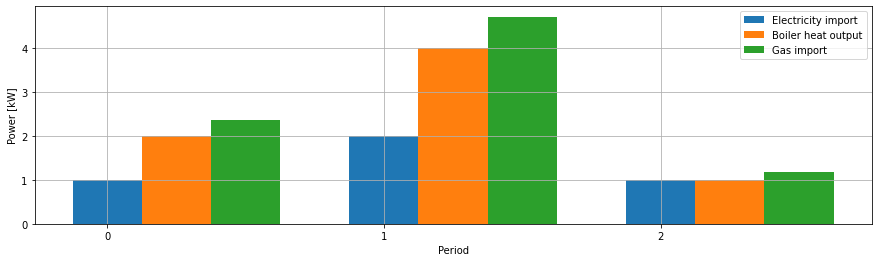

In [12]:
def plot_MES_boiler(model):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15,4))
    plt.bar([0, 1, 2], [y.value for y in model.Electricity_Import.values()],
            label='Electricity import', width=0.25)
    plt.bar([0.25, 1.25, 2.25], [y.value for y in
                                 model.Boiler_Heat_Output.values()],
            label='Boiler heat output', width=0.25)
    plt.bar([0.5, 1.5, 2.5], [y.value for y in model.Gas_Import.values()],
            label='Gas import', width=0.25)
    plt.grid()
    plt.legend()
    plt.xlabel('Period')
    plt.ylabel('Power [kW]')
    plt.xticks(model.Set_Periods)
    plt.show()

plot_MES_boiler(model)

The second visualisation method is the Sankey diagram presented below.

In [13]:
def sankey_MES_Boiler(model):
    import plotly.graph_objects as go

    gas_import = 0
    for period in model.Set_Periods:
        gas_import += model.Gas_Import[period].value
    electricity_demand = sum(model.Electricity_Demand)
    heat_demand = sum(model.Heat_Demand)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
          pad=15,
          thickness=20,
          line=dict(color="black", width=0.5),
          label=["Electricity_Import", "Electricity_Demand", "Gas_Import",
                 "Boiler", "Heat_Demand"],
          color=['deepskyblue', 'blue', 'olive', 'gray', 'deeppink']
        ),
        link=dict(
          source=[0, 2, 3],
          target=[1, 3, 4],
          value=[electricity_demand, gas_import, heat_demand],
          color=['rgba(0,0,255,0.25)', 'rgba(0,255,0,0.25)', 'rgba(255, 0, 0, 0.25)']
        ))])
    # color=['skyblue', 'lightgrey', 'pink']
    
    
    fig.update_layout(title_text="Sankey Diagram", font_size=10)
    fig.show()
sankey_MES_Boiler(model)

Finally, for the sake of convenience, the different methods created to define and solve the model are grouped in dedicated methods:

In [14]:
def add_Boiler(model):
    model.Boiler_Heat_Output = pyo.Var(model.Set_Periods,
                                       domain=pyo.NonNegativeReals)
    model.Boiler_Gas_Input = pyo.Var(model.Set_Periods,
                                     domain=pyo.NonNegativeReals)
    model.Constraint_Boiler_Capacity = pyo.Constraint(model.Set_Periods,
                                                      rule=Boiler_Capacity_rule)
    model.Constraint_Boiler_Operation = pyo.Constraint(model.Set_Periods,
                                                       rule=Boiler_Output_rule)

def build_MES_Boiler_Model(model):
    # Add boiler
    add_Boiler(model)

    # Variables
    model.Electricity_Import = pyo.Var(model.Set_Periods,
                                       domain=pyo.NonNegativeReals)
    model.Gas_Import = pyo.Var(model.Set_Periods, domain=pyo.NonNegativeReals)

    # Constraints
    model.Constraint_Electricity = \
        pyo.Constraint(model.Set_Periods, rule=Electricity_Balance_rule)
    model.Constraint_Heat = \
        pyo.Constraint(model.Set_Periods, rule=Heat_Balance_rule)
    model.Constraint_Gas = \
        pyo.Constraint(model.Set_Periods, rule=Gas_Balance_rule)

    # Objective function
    model.Objective_Function = pyo.Objective(rule=Objective_rule)

    # Solve
    return pyo.SolverFactory('glpk').solve(model)

[Back to top](#Multi-energy-generation-systems---Example-with-gas-boiler)

## Case study

The optimisation model presented in this notebook can be summarised as follows:

**Minimise**
$$
\sum_{period}{\left( Electricity \_ Import \_ Price_{period} \times Electricity \_ Import_{period} + 
                  Gas \_ Import \_ Price_{period} \times Gas \_ Import_{period} \right) \times dt}
$$

**Subject to:**

$$
Boiler \_ Heat \_ Output_{period} \leq Boiler \_ Heat \_ Capacity
$$

$$
Boiler \_ Heat \_ Output_{period} = Boiler \_ Gas \_ Input_{period} \times Boiler \_ Heat \_ Efficiency_{period}
$$

$$
Electricity \_ Demand_{period} = Electricity \_ Import_{period}
$$

$$
Heat \_ Demand_{period} = Boiler \_ Heat \_ Output_{period}
$$

$$
Boiler \_ Gas \_ Input_{period} = Gas \_ Import_{period}
$$

It is now possible to *play* with the MES model by simulating it using the same parameters presented throughout this notebook or changing some of them to explore their impacts of the outputs of the model.

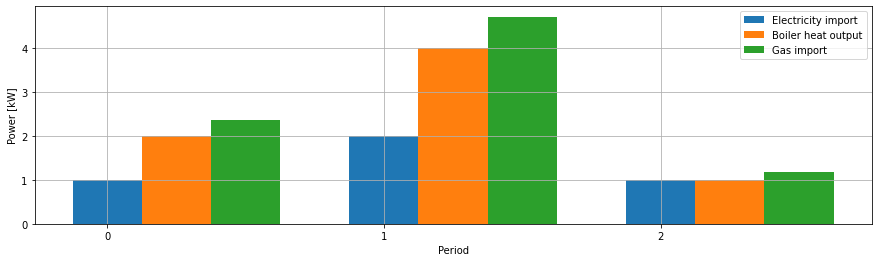

Costs: 1.29 [£]


In [15]:
# Create pyomo object
model = pyo.ConcreteModel()
model.Set_Periods = range(3)

# Add parameters
model.dt = 1
model.Electricity_Demand = [1, 2, 1]  # [kW]
model.Heat_Demand = [2, 4, 1]  # [kW]

model.Electricity_Import_Price = [0.15, 0.20, 0.25]  # [£/kW]
model.Gas_Import_Price = [0.06, 0.06, 0.06]  # [£/kWh]

model.Boiler_Heat_Capacity = 5  # [kW]
model.Boiler_Heat_Efficiency = 0.85  # [pu]

# Solve optimisation problem
results = build_MES_Boiler_Model(model)

# Visualize results
plot_MES_boiler(model)
sankey_MES_Boiler(model)
print('Costs: %.2f'%model.Objective_Function.expr(), '[£]')

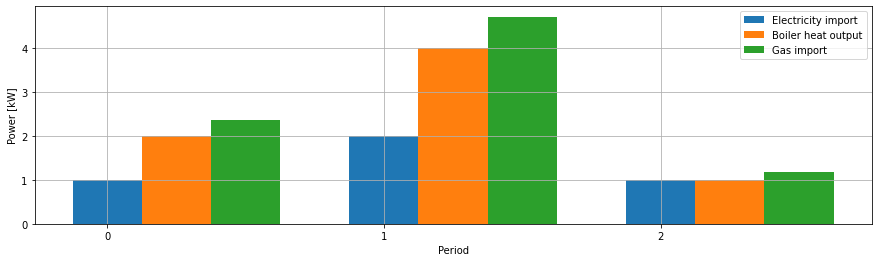

Costs: 2.49 [£]


In [16]:
# Create pyomo object
model = pyo.ConcreteModel()
model.Set_Periods = range(3)

# Add parameters
model.dt = 1
model.Electricity_Demand = [1, 2, 1]  # [kW]
model.Heat_Demand = [2, 4, 1]  # [kW]

model.Electricity_Import_Price = [0.5, 0.5, 0.5]  # [£/kW]
model.Gas_Import_Price = [0.06, 0.06, 0.06]  # [£/kWh]

model.Boiler_Heat_Capacity = 5  # [kW]
model.Boiler_Heat_Efficiency = 0.85  # [pu]

# Solve optimisation problem
results = build_MES_Boiler_Model(model)

# Visualize results
plot_MES_boiler(model)
sankey_MES_Boiler(model)
print('Costs: %.2f'%model.Objective_Function.expr(), '[£]')

[Back to top](#Multi-energy-generation-systems---Example-with-gas-boiler)